In [74]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import umap
import umap.plot
import seaborn as sns
from datasets import build_dataset
from torchvision import datasets, transforms
import moco.builder
import moco.loader
import moco.optimizer

## Augmentation

In [ ]:
  # follow BYOL's augmentation recipe: https://arxiv.org/abs/2006.07733
normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
image_size = 224
augmentation1 = transforms.Compose([transforms.RandomResizedCrop(image_size, scale=(0.08, 1.)),
                 transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.2, 0.1)  # not strengthened
                                         ], p=0.8), transforms.RandomGrayscale(p=0.2),
                 transforms.RandomApply([moco.loader.GaussianBlur([.1, 2.])], p=1.0),
                 transforms.RandomHorizontalFlip(),
                 transforms.ToTensor(), normalize])

augmentation2 = transforms.Compose([
    transforms.RandomResizedCrop(image_size, scale=(0.08, 1.)),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.2, 0.1)  # not strengthened
                            ], p=0.8), transforms.RandomGrayscale(p=0.2),
    transforms.RandomApply([moco.loader.GaussianBlur([.1, 2.])], p=0.1),
    transforms.RandomApply([moco.loader.Solarize()], p=0.2), transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), normalize])
dataset = datasets.CIFAR10(root='data', train=True, download=True)

In [ ]:
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision.transforms as T

def plot(imgs, with_orig=True, titles=None, **imshow_kwargs):
    plt.figure(figsize=(24, 24))
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False,figsize=(15, 15))
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if titles is not None:
        for col_idx in range(1,num_cols):
            print(titles[col_idx-1])
            axs[0, col_idx].title.set_size(8)
            axs[0, col_idx].set(title=titles[col_idx-1])

    plt.show()

In [ ]:
orig_img = dataset[1][0]
t_img_1 = augmentation1(orig_img)
t_img_1 = t_img_1.permute(1,2,0)

t_img_2 = augmentation2(orig_img)
t_img_2 = t_img_2.permute(1,2,0)
plot([t_img_1,t_img_2],True)

In [ ]:
flip = transforms.RandomHorizontalFlip(p=1.0)
t_img_3 = flip(orig_img)

gaussian = transforms.RandomApply([moco.loader.GaussianBlur([.1, 2.])], p=1.0)
t_img_4 = gaussian(orig_img)

jiter = transforms.ColorJitter(0.4, 0.4, 0.2, 0.1) 
t_img_5 = jiter(orig_img)

gray = transforms.RandomGrayscale(p=1.0)
t_img_6 = jiter(orig_img)

titles=['Horizontal Flip','Gaussian Blur','Color Jitter','Gray scale']

plot([t_img_3,t_img_4,t_img_5,t_img_6],True,titles)

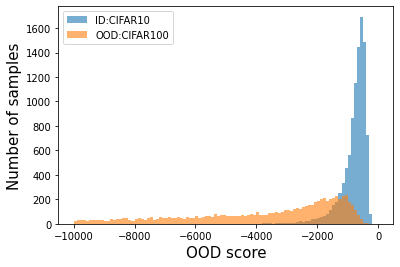

In [39]:
in_scores = torch.load('./data/cifar10_cifar100_dist_cifar10.pt')
ood_scores = torch.load('./data/cifar10_cifar100_dist_cifar100.pt')
id_name = 'cifar10'
ood_name = 'cifar100'
bins_in = in_scores.shape[0] // 100
bins_ood = ood_scores.shape[0] // 100
plt.hist(in_scores.numpy(), range=(-10000,0),bins=bins_in, density=False, alpha=0.6, label='ID:' + id_name.upper())
plt.hist(ood_scores.numpy(), range=(-10000,0),bins=bins_ood, density=False, alpha=0.6, label='OOD:' + ood_name.upper())
plt.xlabel('OOD score',fontsize=15)
plt.ylabel('Number of samples',fontsize=15)
plt.legend()
plt.savefig('./data/cifar10_cifar100_dist.png',dpi=600, bbox_inches='tight')
plt.show()

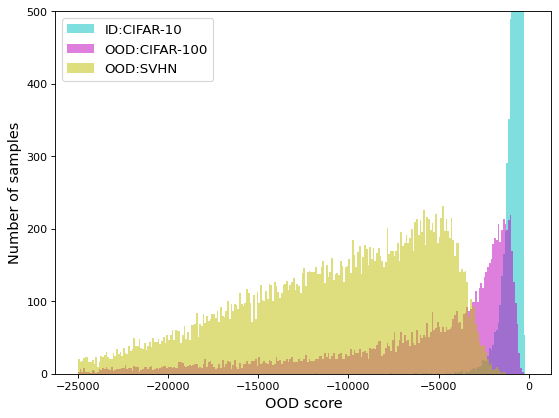

In [79]:
in_scores = torch.load('./data/cifar10_svhn_dist_cifar10.pt')
cifar100_scores = torch.load('./data/cifar10_cifar100_dist_cifar100.pt')
svhn_scores = torch.load('./data/cifar10_svhn_dist_svhn.pt')
id_name = 'cifar10'.upper()
cifar100_name = 'cifar100'.upper()
svhn_name = 'svhn'.upper()
bins_in = in_scores.shape[0] // 100
bins_ood = ood_scores.shape[0] // 100
in_scores = in_scores.numpy()
cifar100_scores = cifar100_scores.numpy()
svhn_scores = svhn_scores.numpy()

# plt.figure(figsize=(8, 6), dpi=80)
plt.hist(in_scores, range=(-25000,0),bins=bins_ood, density=False, alpha=0.5, label='ID:CIFAR-10',color='c')
plt.hist(cifar100_scores, range=(-25000,0),bins=bins_ood, density=False, alpha=0.5, label='OOD:CIFAR-100',color='m')
plt.hist(svhn_scores, range=(-25000,0),bins=bins_ood, density=False, alpha=0.5, label='OOD:SVHN',color='y')
plt.xlabel('OOD score',fontsize=13)
plt.ylabel('Number of samples',fontsize=13)
plt.ylim((0,500))
plt.legend(fontsize=12)
plt.savefig('./data/cifar10_cifar100_svhn_dist.png',dpi=600, bbox_inches='tight')
plt.show()

## Visualization of distribution

/Users/aaron/PycharmProjects/oodformer-master/venv/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  return f(**kwargs)
/Users/aaron/PycharmProjects/oodformer-master/venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


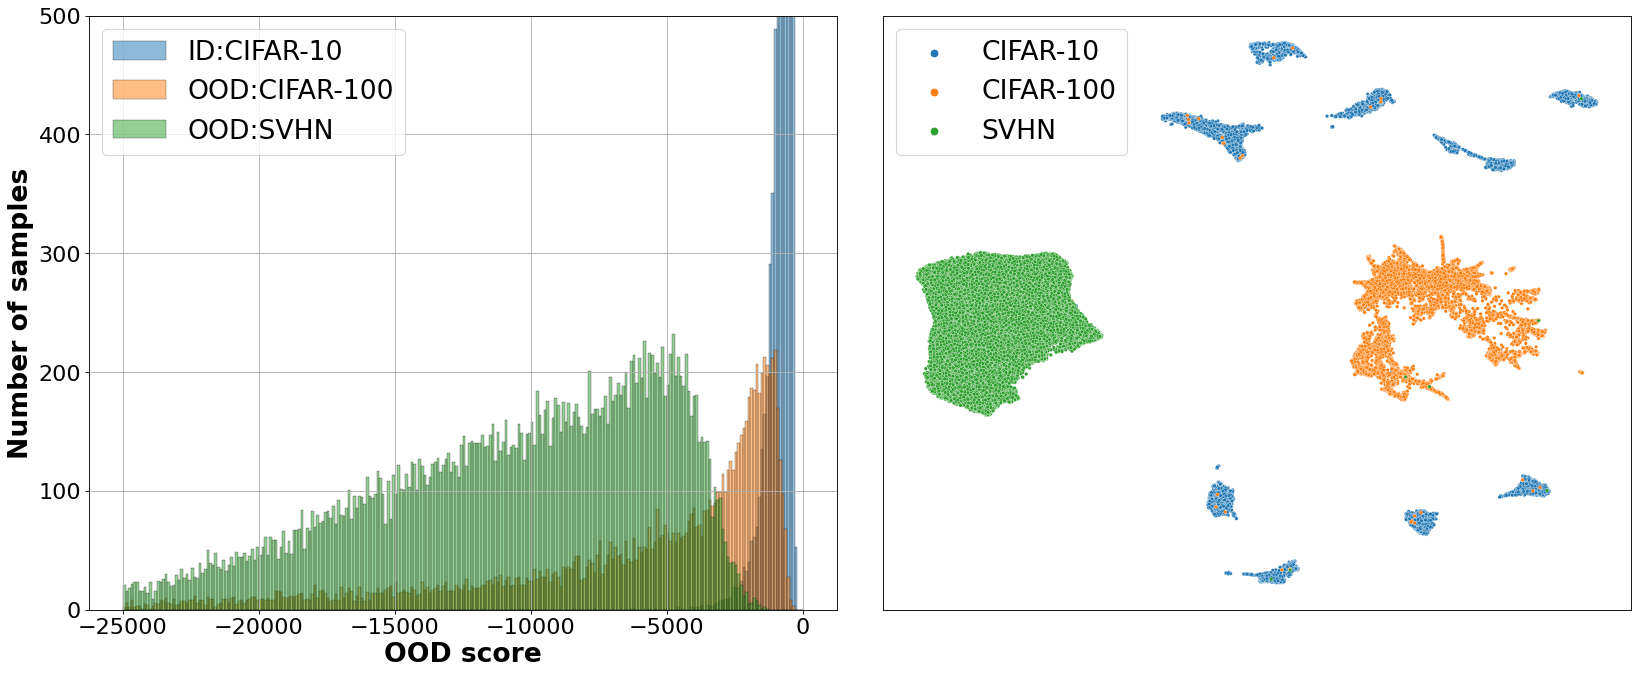

In [277]:
in_scores = torch.load('./data/cifar10_svhn_dist_cifar10.pt')
cifar100_scores = torch.load('./data/cifar10_cifar100_dist_cifar100.pt')
svhn_scores = torch.load('./data/cifar10_svhn_dist_svhn.pt')
id_name = 'cifar10'.upper()
cifar100_name = 'cifar100'.upper()
svhn_name = 'svhn'.upper()
bins_in = in_scores.shape[0] // 100
bins_ood = ood_scores.shape[0] // 100
in_scores = in_scores.numpy()
cifar100_scores = cifar100_scores.numpy()
svhn_scores = svhn_scores.numpy()

fig, (ax1, ax2) = plt.subplots(1,2,figsize = (20,8),dpi=80)
fig.tight_layout()
# plt.subplots_adjust(wspace =10, hspace =0)

# plt.figure(figsize=(8, 6), dpi=80)
sns.histplot(in_scores, binrange=(-25000,0),bins=bins_ood,  alpha=0.5, label='ID:CIFAR-10',ax=ax1,color='tab:blue')
sns.histplot(cifar100_scores, binrange=(-25000,0),bins=bins_ood,  alpha=0.5, label='OOD:CIFAR-100',ax=ax1,color='tab:orange')
sns.histplot(svhn_scores, binrange=(-25000,0),bins=bins_ood,  alpha=0.5, label='OOD:SVHN',ax=ax1,color='tab:green')
ax1.grid()
ax1.set_xlabel('OOD score',fontsize=26,fontweight="bold")
ax1.set_ylabel('Number of samples',fontsize=26,fontweight="bold")
ax1.set_ylim((0,500))
ax1.legend(fontsize=24)
ax1.tick_params(labelsize=20)

## right
cifar10 = torch.load('./data/cifar10.pt')
cifar100 = torch.load('./data/cifar100.pt')
svhn = torch.load('./data/svhn.pt')
data = torch.cat([cifar10,cifar100,svhn])
labels = np.array(['CIFAR-10'] * len(cifar10) +['CIFAR-100']*len(cifar100)+ ['SVHN'] * len(svhn))
targets = np.array([0] * len(cifar10) +[1]*len(cifar100)+ [2] * len(svhn))
embedding = umap.UMAP().fit_transform(data.numpy(),y=labels)
sns.scatterplot(*embedding.T, ax=ax2, hue=labels, s=10)
ax2.legend(fontsize=24)
ax2.set_xticks([])
ax2.set_yticks([])
# ax2.set_xlabel('Visualization of feature embeddings',fontsize=26)
plt.savefig('./data/distribution.png',dpi=300, bbox_inches='tight')
plt.show()

In [128]:
en_cifar10_cifar100=np.array([0.950863735,0.958886035,0.958817905,0.95995834,0.9603297,0.958772895,0.95985453,0.96060944,0.960592995,0.95920146,0.958646175,0.95775758,0.959370835,0.958716455,0.95878668,0.958946395,0.958616705,0.95882561,0.95871882,0.95857809])
en_cifar10_svhn=np.array([0.997189862,0.99863032,0.99903405,0.999243281,0.99931401,0.999271086,0.999395475,0.999330301,0.99938904,0.99941474,0.999378054,0.999367452,0.999415565,0.999401026,0.999393116,0.999380601,0.999385787,0.999381803,0.99938498,0.999389521])

predictor_cifar10_cifar100=np.array([0.936707325,0.95552206,0.956706345,0.95808746,0.96227946,0.96485841,0.963665015,0.965379855,0.961263795,0.963948305,0.96113694,0.960917655,0.96063502,0.95952291,0.961743825,0.961801455,0.95974923,0.961395895,0.959738515,0.96101247])
predictor_cifar10_svhn=np.array([0.988197712,0.990556169,0.993595438,0.994244136,0.994905165,0.994145473,0.992378185,0.99115936,0.991263107,0.991301775,0.98931908,0.989742181,0.988405945,0.98532443,0.985946923,0.985957566,0.98705673,0.983600215,0.983662696,0.983581724])

In [146]:
res_encoder_cifar10_cifar100=np.array([0.58020363,0.533543315,0.47768122,0.506763225,0.56673663,0.47364786,0.53155489,0.562033,0.47096762,0.507677325,0.43600454,0.495730435,0.54445067,0.465236265,0.44817756,0.44209218,0.461974155,0.58494065,0.493295365,0.478470935])
res_predictor_cifar10_cifar100=np.array([0.69680449,0.70351606,0.693028305,0.7039281,0.68883883,0.6892828,0.68501616,0.68571737,0.67410809,0.678823555,0.68772626,0.677543805,0.687794065,0.67517757,0.67697759,0.6843681,0.669576385,0.676788645,0.6851322,0.673833025])
res_encoder_cifar10_svhn=np.array([0.514870755,0.79369718,0.378479809,0.436791115,0.398428396,0.373757124,0.372937715,0.590678699,0.499657462,0.788577311,0.576425202,0.580933428,0.510511874,0.325863643,0.308088708,0.299389281,0.38511976,0.548967106,0.684758004,0.676812026])
res_predictor_cifar10_svhn=np.array([0.999325069,0.997691585,0.997611624,0.997987542,0.99748004,0.996849309,0.995802485,0.996138291,0.995732329,0.995327873,0.995435466,0.994402975,0.994754635,0.993409254,0.995963935,0.995274337,0.994581068,0.994989125,0.994733709,0.995024362])

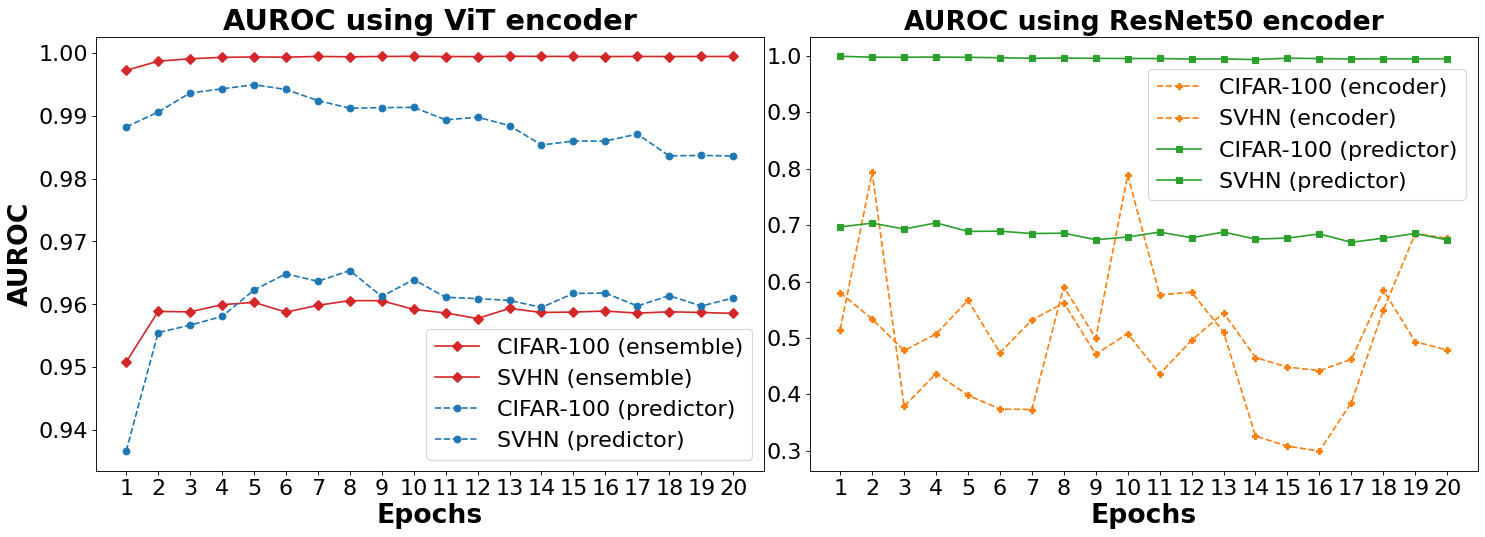

In [276]:
fig, ax = plt.subplots(1,2,figsize = (18,6),dpi=80)
fig.tight_layout()
ax[0].plot(en_cifar10_cifar100, label='CIFAR-100 (ensemble)',color='tab:red',marker='D')
ax[0].plot(en_cifar10_svhn, label='SVHN (ensemble)',color='tab:red',marker='D')
ax[0].plot(predictor_cifar10_cifar100,'g--', label='CIFAR-100 (predictor)',color='tab:blue',marker='o')
ax[0].plot(predictor_cifar10_svhn,'g--', label='SVHN (predictor)',color='tab:blue',marker='o')
ax[0].set_xlabel('Epochs',fontsize=24,fontweight="bold")
ax[0].set_ylabel('AUROC',fontsize=24,fontweight="bold")
# ax[0].set_ylim((0,1))
ax[0].set_xticks(range(20))
ax[0].set_xticklabels (range(1,21))
ax[0].legend(fontsize=20)
ax[0].tick_params(labelsize=20)
ax[0].set_title('AUROC using ViT encoder',fontsize=26,fontweight="bold")

ax[1].plot(res_encoder_cifar10_cifar100,'g--', label='CIFAR-100 (encoder)',color='tab:orange',marker='P')
ax[1].plot(res_encoder_cifar10_svhn,'g--', label='SVHN (encoder)',color='tab:orange',marker='P')
ax[1].plot(res_predictor_cifar10_cifar100, label='CIFAR-100 (predictor)',color='tab:green',marker='s')
ax[1].plot(res_predictor_cifar10_svhn, label='SVHN (predictor)',color='tab:green',marker='s')
ax[1].set_xlabel('Epochs',fontsize=24,fontweight="bold")
# ax[0].set_ylim((0,1))
ax[1].set_xticks(range(20))
ax[1].set_xticklabels (range(1,21))
ax[1].legend(fontsize=20,bbox_to_anchor=(0,0,1,0.95))
ax[1].tick_params(labelsize=20)
ax[1].set_title('AUROC using ResNet50 encoder',fontsize=24,fontweight="bold")
plt.savefig('./data/trends.png',dpi=300, bbox_inches='tight')
plt.show()

In [190]:
clusters_cifar10_cifar100=np.array([0.9649,0.7710,0.7770,0.7539,0.7491,0.7415,0.7397,0.7502,0.7554,0.7529])
clusters_cifar10_svhn=np.array([0.9941,0.7755,0.8484,0.7912,0.7987,0.7933,0.8059,0.8239,0.8221,0.8072])

t1_cifar10_cifar100=np.array([0.6505,0.9414,0.9648,0.9581])
t1_cifar10_svhn=np.array([0.7494,0.9851,0.9941,0.9929])

t10_cifar10_cifar100=np.array([0.7223,0.7369,0.7529,0.7698])
t10_cifar10_svhn=np.array([0.8347,0.8138,0.8072,0.8466])
ts = ['0.07','0.2','0.5','08']

# dim_e_cifar10_cifar100=np.array([95.05,96.48,96.61,96.56])
# dim_e_cifar10_svhn=np.array([99,99.41,99.42,99.62])
# dim_p_cifar10_cifar100=np.array([95.05,96.48,96.61,96.56])
# dim_p_cifar10_svhn=np.array([99,99.41,99.42,99.62])

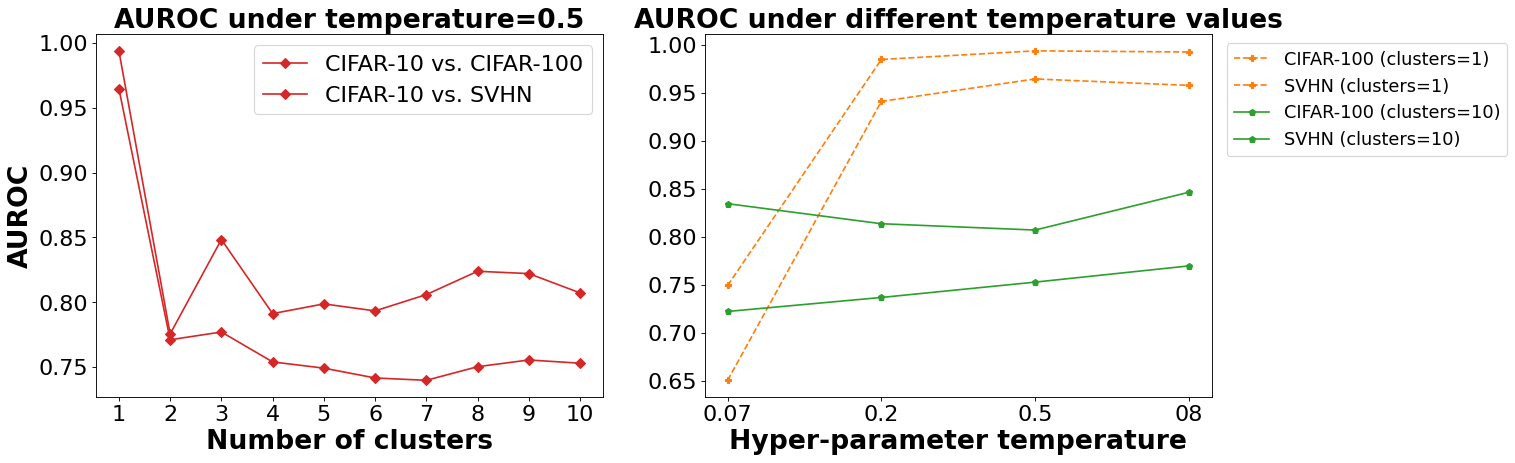

In [275]:
fig, ax = plt.subplots(1,2,figsize = (18,6),dpi=80)
# fig.tight_layout()
ax[0].plot(clusters_cifar10_cifar100, label='CIFAR-10 vs. CIFAR-100',color='tab:red',marker='D')
ax[0].plot(clusters_cifar10_svhn, label='CIFAR-10 vs. SVHN',color='tab:red',marker='D')
ax[0].set_xlabel('Number of clusters',fontsize=24,fontweight="bold")
ax[0].set_ylabel('AUROC',fontsize=24,fontweight="bold")
# ax[0].set_ylim((0,1))
ax[0].set_xticks(range(10))
ax[0].set_xticklabels (range(1,11))
ax[0].legend(fontsize=20)
ax[0].tick_params(labelsize=20)
ax[0].set_title('AUROC under temperature=0.5',fontsize=24,fontweight="bold")

ax[1].plot(t1_cifar10_cifar100,'g--', label='CIFAR-100 (clusters=1)',color='tab:orange',marker='P')
ax[1].plot(t1_cifar10_svhn,'g--', label='SVHN (clusters=1)',color='tab:orange',marker='P')
ax[1].plot(t10_cifar10_cifar100, label='CIFAR-100 (clusters=10)',color='tab:green',marker='p')
ax[1].plot(t10_cifar10_svhn, label='SVHN (clusters=10)',color='tab:green',marker='p')
ax[1].set_xlabel('Hyper-parameter temperature',fontsize=24,fontweight="bold")
# ax[0].set_ylim((0,1))
ax[1].set_xticks(range(4))
ax[1].set_xticklabels(ts)
ax[1].legend(fontsize=16,bbox_to_anchor=(1,0,0.6,1))
ax[1].tick_params(labelsize=20)
ax[1].set_title('AUROC under different temperature values',fontsize=24,fontweight="bold")
plt.savefig('./data/clusters.png',dpi=300, bbox_inches='tight')
plt.show()

In [295]:
vit_cifar10_cifar100 = np.array([0.965561755,0.1663,0.963165194])
vit_cifar10_svhn = np.array([0.99628004,0.012484634,0.991892486])

swin_cifar10_cifar100 = np.array([0.960883015,0.1927,0.958002412])
swin_cifar10_svhn = np.array([0.99474628,0.026889982,0.987665933])

resnet_cifar10_cifar100 = np.array([0.70631935,0.8371,0.698732169])
resnet_cifar10_svhn = np.array([0.999142628,0.00180547,0.998170939])

cifar10_cifar100 = np.stack((vit_cifar10_cifar100,swin_cifar10_cifar100,resnet_cifar10_cifar100),axis=0)
cifar10_svhn = np.stack((vit_cifar10_svhn,swin_cifar10_svhn,resnet_cifar10_svhn),axis=0)
cifar10_cifar100

array([[0.96556175, 0.1663    , 0.96316519],
       [0.96088301, 0.1927    , 0.95800241],
       [0.70631935, 0.8371    , 0.69873217]])

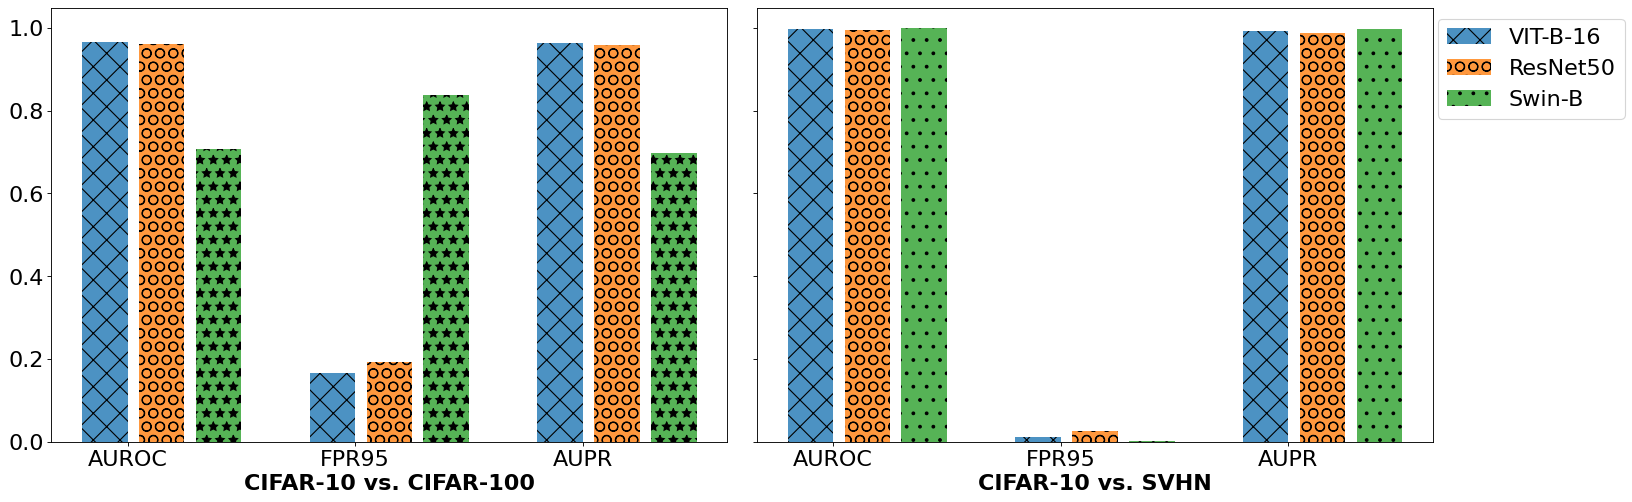

In [350]:
fig, ax = plt.subplots(1,2,figsize = (18,6),dpi=80,sharey=True)
fig.tight_layout()
tick_label=['AUROC','FPR95','AUPR']

x = np.arange(3)
total_width, n = 0.6, 3
width = total_width / n
x = x - (total_width - width) / 2

p1=ax[0].bar(x, cifar10_cifar100[0],  width=width, label='VIT-B-16',hatch='x',alpha=0.8)

cm=ax[0].bar(x + width+0.05, cifar10_cifar100[1], width=width, label='ResNet50',hatch='O',alpha=0.8)
p3=ax[0].bar(x + 2 * (width+0.05), cifar10_cifar100[2], width=width, label='Swin-B',hatch='*',alpha=0.8)
ax[0].set_xticks(x+width/2)
ax[0].set_xticklabels (tick_label)
ax[0].tick_params(labelsize=20)
ax[0].set_xlabel('CIFAR-10 vs. CIFAR-100',fontsize=20,fontweight="bold")
# ax[0].axhline(0.4, color='r', linewidth=0.8)


ax[1].bar(x, cifar10_svhn[0],  width=width,label='VIT-B-16',hatch='x',alpha=0.8)
ax[1].bar(x + width+0.05, cifar10_svhn[1], width=width, label='ResNet50',hatch='O',alpha=0.8)
ax[1].bar(x + 2 * (width+0.05), cifar10_svhn[2], width=width, label='Swin-B',hatch='.',alpha=0.8)
ax[1].legend(fontsize=20,bbox_to_anchor=(0.7,0,0.6,1))
ax[1].set_xticks(x+width/2)
ax[1].set_xticklabels (tick_label)
ax[1].set_xlabel('CIFAR-10 vs. SVHN',fontsize=20,fontweight="bold")
ax[1].tick_params(labelsize=20)

plt.show()